In [7]:
import xarray as xr
import glob
import os

In [8]:
filepath = "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240213/"
files = glob.glob(os.path.join(filepath, "*.nc"))

In [17]:

# sort files and remove datasets before November
files = sorted(files)[3:]

In [18]:
from sublimpy import utils

In [19]:
datasets = []
for fn in files:
    ds = xr.open_dataset(fn)
    datasets.append(ds)

In [20]:
sos_ds = utils.merge_datasets_with_different_variables(datasets, dim='time')

In [21]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [24]:
sos_hourly_ds = sos_ds.resample(time='60Min').mean()

In [25]:
sos_hourly_ds

<xarray.Dataset>
Dimensions:                    (sites: 4, time: 5544)
Coordinates:
  * sites                      (sites) |S2 b'd' b'ue' b'uw' b'c'
  * time                       (time) datetime64[ns] 2022-11-01 ... 2023-06-1...
Data variables: (12/1307)
    latitude_d                 (time) float64 38.94 38.94 38.94 ... 38.94 38.94
    longitude_d                (time) float64 -107.0 -107.0 ... -107.0 -107.0
    altitude_d                 (time) float64 2.866e+03 2.866e+03 ... 2.866e+03
    latitude_ue                (time) float64 38.94 38.94 38.94 ... 38.94 38.94
    longitude_ue               (time) float64 -107.0 -107.0 ... -107.0 -107.0
    altitude_ue                (time) float64 2.867e+03 2.867e+03 ... 2.867e+03
    ...                         ...
    u_u__2_5m_uw               (time, sites) float64 nan nan nan ... nan nan nan
    w_tc__2_5m_uw              (time, sites) float64 nan nan nan ... nan nan nan
    counts_2_5m_uw_2           (time, sites) float64 nan nan nan ... nan nan nan
    u_v_w__2_5m_uw             (time, sites) float64 nan nan nan ... nan nan nan
    h2o_2_5m_uw                (time, sites) float64 nan nan nan ... nan nan nan
    u_w_w__2_5m_uw             (time, sites) float64 nan nan nan ... nan nan nan
Attributes:
    project:                   SOS
    history:                   Created: 2023-11-14 02:16:36 +0000\n
    NIDAS_version:             v1.2.1-8
    calibration_file_path:     /net/isf/isff/projects/SOS/ISFS/cal_files/$SIT...
    dataset:                   qc_geo_tiltcor
    dataset_description:       QC, winds in geographic, tilt corrected coordi...
    project_config:            /net/isf/isff/projects/SOS/ISFS/config/sos.xml;
    wind3d_horiz_coordinates:  geographic
    file_length_seconds:       86400
    wind3d_horiz_rotation:     1
    wind3d_tilt_correction:    1

In [26]:
sos_hourly_ds.to_netcdf('sos_hourly_ds.nc')

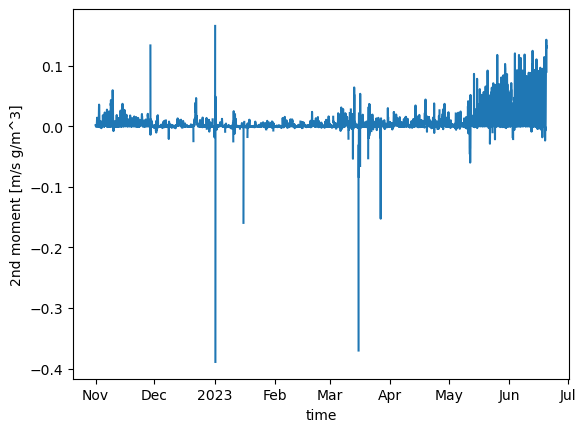

In [32]:
sos_hourly_ds['w_h2o__10m_d'].plot()

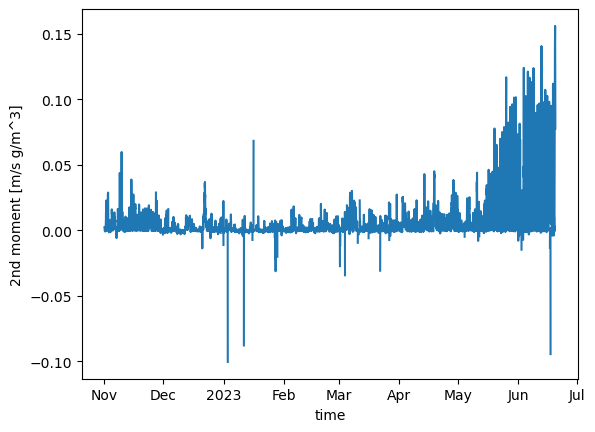

In [31]:
sos_hourly_ds['w_h2o__3m_c'].plot()